# Load Packages

In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Import packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import PIL
import pathlib
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
import requests
import pyunpack
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import sys

from rarfile import RarFile
import segmentation_models as sm
from keras_segmentation.models import segnet
from tensorflow.keras.applications import vgg16
from sklearn.metrics import *
import rioxarray as rxr
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Segmentation Models: using `tf.keras` framework.


/opt/homebrew/anaconda3/envs/ai_presentation/lib/python3.9/site-packages/imageio/core/util.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Functions

In [2]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  # # Single tile case: shape (H,W,6)
  # if images.ndim == 3:
  #     x = images[np.newaxis, ...]      # (1,H,W,6)
  #     y_true = masks.reshape(-1)
  #     y_pred = model.predict(x)[0, :, :, 0]
  #     y_pred = np.round(y_pred).astype(int).reshape(-1)
  #     return accuracy_score(y_true, y_pred)

  # # Batch case: shape (N,H,W,6)
  # N = images.shape[0]
  # scores = []
  # for i in range(N):
  #     x = images[i:i+1, ...]           # (1,H,W,6)
  #     y_true = masks[i].reshape(-1)
  #     y_pred = model.predict(x)[0, :, :, 0]
  #     y_pred = np.round(y_pred).astype(int).reshape(-1)
  #     scores.append(accuracy_score(y_true, y_pred))
  # return scores
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  # # Single tile case: shape (H,W,6)
  # if images.ndim == 3:
  #     x = images[np.newaxis, ...]      # (1,H,W,6)
  #     y_true = masks.reshape(-1)
  #     y_pred = model.predict(x)[0, :, :, 0]
  #     y_pred = np.round(y_pred).astype(int).reshape(-1)
  #     return recall_score(y_true, y_pred, average="weighted")

  # # Batch case: shape (N,H,W,6)
  # N = images.shape[0]
  # recalls = []
  # for i in range(N):
  #     x = images[i:i+1, ...]           # (1,H,W,6)
  #     y_true = masks[i].reshape(-1)
  #     y_pred = model.predict(x)[0, :, :, 0]
  #     y_pred = np.round(y_pred).astype(int).reshape(-1)
  #     recalls.append(recall_score(y_true, y_pred, average="weighted"))
  # return recalls
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  # # Single tile case: shape (H,W,6)
  # if images.ndim == 3:
  #     x = images[np.newaxis, ...]      # (1,H,W,6)
  #     y_true = masks.reshape(-1)
  #     y_pred = model.predict(x)[0, :, :, 0]
  #     y_pred = np.round(y_pred).astype(int).reshape(-1)
  #     return precision_score(y_true, y_pred, average="weighted")

  # # Batch case: shape (N,H,W,6)
  # N = images.shape[0]
  # precisions = []
  # for i in range(N):
  #     x = images[i:i+1, ...]           # (1,H,W,6)
  #     y_true = masks[i].reshape(-1)
  #     y_pred = model.predict(x)[0, :, :, 0]
  #     y_pred = np.round(y_pred).astype(int).reshape(-1)
  #     precisions.append(precision_score(y_true, y_pred, average="weighted"))
  # return precisions
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

# Ingest and Process 4-band Dataset

In [ ]:
# Ingest images and normalise
base_dir2 = r"./mangrove_datasets/MAHAKAM_4band_10m/"

## Training images
training_images_list2 = os.listdir(r"{}Training/images/".format(base_dir2))[0:250]
training_masks_list2 = []
training_images2 = []
for n in training_images_list2:
  if n == '.DS_Store':
    continue
  training_masks_list2.append((n[:-4]+'.png'))
  a = (np.array(rxr.open_rasterio(r"{}Training/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images2.append(a)

## Training masks
training_masks2 = []
for n in training_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Training/masks/{}".format(base_dir2,n))))
  training_masks2.append(a)

## Test images
test_images_list2 = os.listdir(r"{}Test/".format(base_dir2))
test_images2 = []
for n in test_images_list2:
  if n == '.DS_Store':
    continue
  a = (np.array(rxr.open_rasterio(r"{}Test/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images2.append(a)

## Validation images
validation_images_list2 = os.listdir(r"{}Validation/images/".format(base_dir2))
validation_masks_list2 = []
validation_images2 = []
for n in validation_images_list2:
  if n == '.DS_Store':
    continue
  validation_masks_list2.append(n[:-4]+'.png')
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images2.append(a)

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n))))
  validation_masks2.append(a)

/opt/homebrew/anaconda3/envs/ai_presentation/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/opt/homebrew/anaconda3/envs/ai_presentation/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/opt/homebrew/anaconda3/envs/ai_presentation/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/opt/homebrew/anaconda3/envs/ai_presentation/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no 

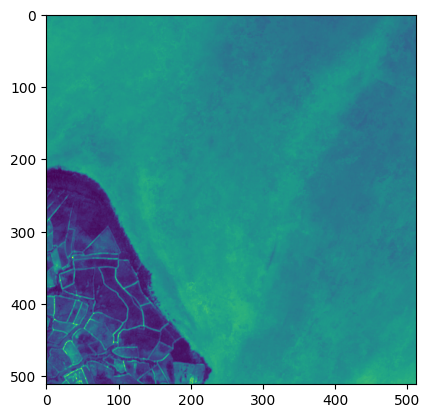

In [4]:
# Show example train image
plt.imshow((np.array(rxr.open_rasterio(r"{}Training/images/{}".format(base_dir2,training_images_list2[20])))[0,:,:]))

In [5]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  m = np.array(training_masks2[i]).astype('float32')
  m = (m > 0).astype('float32')
  m = m.reshape(1,512,512,1)
  training_masks2[i] = m.T

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  m = np.array(validation_masks2[i]).astype('float32')
  m = (m > 0).astype('float32')
  m = m.reshape(1,512,512,1)
  validation_masks2[i] = m.T

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

In [6]:
# # Create TensorFlow datasets for training and validation sets
train_df_4band_amazon = tf.data.Dataset.from_tensor_slices((training_images2[0:250], training_masks2[0:250]))
validation_df_4band_amazon = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

# Models

## U-Net (Unmodified)

In [7]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
'''
  U-Net model
'''

def UNet(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [27]:
# Print model layers and number of parameters
UNet().summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(1, 512, 512, 3)]           0         []                            
                                                                                                  
 conv2d_76 (Conv2D)          (1, 512, 512, 64)            1792      ['input_5[0][0]']             
                                                                                                  
 activation_64 (Activation)  (1, 512, 512, 64)            0         ['conv2d_76[0][0]']           
                                                                                                  
 conv2d_77 (Conv2D)          (1, 512, 512, 64)            36928     ['activation_64[0][0]']       
                                                                                            

## Attention U-Net (Unmodified)

In [8]:
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose,
    MaxPooling2D, UpSampling2D, Activation, concatenate, add, Multiply, BatchNormalization, LeakyReLU, Dropout
)

'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,6), drop_rate = 0.25, lr=0.0001, filter_base=16, se_reduction=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [28]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(1, 512, 512, 6)]           0         []                            
                                                                                                  
 conv2d_95 (Conv2D)          (1, 512, 512, 16)            880       ['input_6[0][0]']             
                                                                                                  
 activation_83 (Activation)  (1, 512, 512, 16)            0         ['conv2d_95[0][0]']           
                                                                                                  
 conv2d_96 (Conv2D)          (1, 512, 512, 16)            2320      ['activation_83[0][0]']       
                                                                                            

## Modified Attention U-Net (with Batch Normalization, Leaky ReLU Activation, and Dropout)

In [31]:
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose,
    MaxPooling2D, UpSampling2D, Activation, concatenate, add, Multiply, BatchNormalization, LeakyReLU, Dropout
)

def advancedConvBlock2(input, filters, kernel, kernel_init='he_normal', transpose=False, use_dropout=False, dropout_rate=0.3):
  if transpose == False:
    conv = Conv2D(filters,
                               kernel,
                               padding='same',
                               kernel_initializer=kernel_init,
                               use_bias=False)(input)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2D(filters,
                            kernel,
                            padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)
  else:
    conv = Conv2DTranspose(filters,
                            kernel,
                            padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(input)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2DTranspose(filters,
                            kernel,
                            padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

  if use_dropout:
      conv = Dropout(dropout_rate)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM_Optimized(trained_weights = None, input_size = (512,512,6), drop_rate = 0.25, lr=0.0001, filter_base=16, se_reduction=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = advancedConvBlock2(inputs, filter_base, kernel=3, use_dropout=False)


    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = advancedConvBlock2(conv0, 2 * filter_base, kernel=3, use_dropout=False)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = advancedConvBlock2(pool0, 4 * filter_base, kernel=3,
                          use_dropout=True, dropout_rate=drop_rate)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = advancedConvBlock2(pool1, 8 * filter_base, kernel=3,
                          use_dropout=True, dropout_rate=drop_rate)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = advancedConvBlock2(pool2, 16 * filter_base, kernel=3,
                          use_dropout=True, dropout_rate=drop_rate)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = advancedConvBlock2(conv4, 8 * filter_base, kernel=3, use_dropout=False)


    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = advancedConvBlock2(conv5, 4 * filter_base, kernel=3, use_dropout=False)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = advancedConvBlock2(conv6, 2 * filter_base, kernel=3, use_dropout=False)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = advancedConvBlock2(conv7, 1 * filter_base, kernel=3, use_dropout=False)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [32]:
# Print model layers and number of parameters
UNetAM_Optimized().summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(1, 512, 512, 6)]           0         []                            
                                                                                                  
 conv2d_152 (Conv2D)         (1, 512, 512, 16)            864       ['input_9[0][0]']             
                                                                                                  
 batch_normalization_72 (Ba  (1, 512, 512, 16)            64        ['conv2d_152[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_72 (LeakyReLU)  (1, 512, 512, 16)            0         ['batch_normalization_72

## Mini Attention U-Net (Same as above but using Separable Depthwise Convolution)

In [10]:
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, SeparableConv2D,
    MaxPooling2D, UpSampling2D, Activation, concatenate, add, Multiply, BatchNormalization, LeakyReLU, Dropout
)

def advancedConvBlock2(input, filters, kernel, kernel_init='he_normal', transpose=False, use_dropout=False, dropout_rate=0.3):
  if transpose == False:
    conv = SeparableConv2D(filters,
                               kernel,
                               padding='same',
                               kernel_initializer=kernel_init,
                               use_bias=False)(input)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = SeparableConv2D(filters,
                            kernel,
                            padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)
  else:
    conv = Conv2DTranspose(filters,
                            kernel,
                            padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(input)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2DTranspose(filters,
                            kernel,
                            padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

  if use_dropout:
      conv = Dropout(dropout_rate)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM_Mini(trained_weights = None, input_size = (512,512,6), drop_rate = 0.25, lr=0.0001, filter_base=16, se_reduction=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = advancedConvBlock2(inputs, filter_base, kernel=3, use_dropout=False)


    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = advancedConvBlock2(conv0, 2 * filter_base, kernel=3, use_dropout=False)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = advancedConvBlock2(pool0, 4 * filter_base, kernel=3,
                          use_dropout=True, dropout_rate=drop_rate)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = advancedConvBlock2(pool1, 8 * filter_base, kernel=3,
                          use_dropout=True, dropout_rate=drop_rate)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = advancedConvBlock2(pool2, 16 * filter_base, kernel=3,
                          use_dropout=True, dropout_rate=drop_rate)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = advancedConvBlock2(conv4, 8 * filter_base, kernel=3, use_dropout=False)


    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = advancedConvBlock2(conv5, 4 * filter_base, kernel=3, use_dropout=False)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = advancedConvBlock2(conv6, 2 * filter_base, kernel=3, use_dropout=False)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = advancedConvBlock2(conv7, 1 * filter_base, kernel=3, use_dropout=False)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [30]:
# Print model layers and number of parameters
UNetAM_Mini().summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(1, 512, 512, 6)]           0         []                            
                                                                                                  
 separable_conv2d_54 (Separ  (1, 512, 512, 16)            150       ['input_8[0][0]']             
 ableConv2D)                                                                                      
                                                                                                  
 batch_normalization_54 (Ba  (1, 512, 512, 16)            64        ['separable_conv2d_54[0][0]'] 
 tchNormalization)                                                                                
                                                                                            

# Train on 4-band data

### U-Net

In [ ]:
# Train U-Net with generator
model_unet_4band = UNet(input_size=(512,512,4), lr=0.0001)
save_model_4band = ModelCheckpoint('mahakam_mangrove_models/unet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band.fit(train_df_4band_amazon, epochs = 20, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band])

Epoch 1/20
30/30 [==============================] - ETA: 0s - loss: 0.3962 - accuracy: 0.8425 - mse: 0.1266
Epoch 1: val_accuracy improved from -inf to 0.92925, saving model to unet-4d.hdf5
30/30 [==============================] - 86s 3s/step - loss: 0.3962 - accuracy: 0.8425 - mse: 0.1266 - val_loss: 0.2236 - val_accuracy: 0.9293 - val_mse: 0.0611
Epoch 2/20


/opt/homebrew/anaconda3/envs/ai_presentation/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.8925 - mse: 0.0802
Epoch 2: val_accuracy improved from 0.92925 to 0.93625, saving model to unet-4d.hdf5
30/30 [==============================] - 82s 3s/step - loss: 0.2616 - accuracy: 0.8925 - mse: 0.0802 - val_loss: 0.1911 - val_accuracy: 0.9362 - val_mse: 0.0517
Epoch 3/20
30/30 [==============================] - ETA: 0s - loss: 0.2413 - accuracy: 0.9057 - mse: 0.0731
Epoch 3: val_accuracy did not improve from 0.93625
30/30 [==============================] - 81s 3s/step - loss: 0.2413 - accuracy: 0.9057 - mse: 0.0731 - val_loss: 0.2053 - val_accuracy: 0.9359 - val_mse: 0.0540
Epoch 4/20
30/30 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.9079 - mse: 0.0712
Epoch 4: val_accuracy did not improve from 0.93625
30/30 [==============================] - 78s 3s/step - loss: 0.2353 - accuracy: 0.9079 - mse: 0.0712 - val_loss: 0.1918 - val_accuracy: 0.9342 - val_mse: 0.0521
Epoch 5/20
30/30 

In [ ]:
# Save model history
np.save('mahakam_mangrove_models/unet-4d-history.npy',model_unet_4band.history.history)

### Attention U-Net (Unmodified)

In [ ]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('mahakam_mangrove_models/unet-attention-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/60
30/30 [==============================] - ETA: 0s - loss: 0.6178 - accuracy: 0.7338 - mse: 0.2142
Epoch 1: val_accuracy improved from -inf to 0.89584, saving model to unet-attention-4d.hdf5
30/30 [==============================] - 12s 353ms/step - loss: 0.6178 - accuracy: 0.7338 - mse: 0.2142 - val_loss: 0.3975 - val_accuracy: 0.8958 - val_mse: 0.1230
Epoch 2/60
30/30 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.8755 - mse: 0.1007
Epoch 2: val_accuracy improved from 0.89584 to 0.91532, saving model to unet-attention-4d.hdf5
30/30 [==============================] - 10s 347ms/step - loss: 0.3179 - accuracy: 0.8755 - mse: 0.1007 - val_loss: 0.2622 - val_accuracy: 0.9153 - val_mse: 0.0746
Epoch 3/60
30/30 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.9009 - mse: 0.0799
Epoch 3: val_accuracy improved from 0.91532 to 0.93647, saving model to unet-attention-4d.hdf5
30/30 [==============================] - 10s 347ms/step - loss: 0.

In [ ]:
# Save model history
np.save('mahakam_mangrove_models/unet-attention-4d-history.npy',model_attention_unet_4band.history.history)

### Modified Attention U-Net (with Batch Normalization, Leaky ReLU Activation, and Dropout)

In [ ]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM_Optimized(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('mahakam_mangrove_models/unet-attention-4d_optimized.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/60
30/30 [==============================] - ETA: 0s - loss: 0.6009 - accuracy: 0.7341 - mse: 0.2051
Epoch 1: val_accuracy improved from -inf to 0.60316, saving model to unet-attention-4d_optimized.hdf5
30/30 [==============================] - 11s 289ms/step - loss: 0.6009 - accuracy: 0.7341 - mse: 0.2051 - val_loss: 0.6903 - val_accuracy: 0.6032 - val_mse: 0.2486
Epoch 2/60
30/30 [==============================] - ETA: 0s - loss: 0.4459 - accuracy: 0.8790 - mse: 0.1357
Epoch 2: val_accuracy improved from 0.60316 to 0.60316, saving model to unet-attention-4d_optimized.hdf5
30/30 [==============================] - 9s 290ms/step - loss: 0.4459 - accuracy: 0.8790 - mse: 0.1357 - val_loss: 0.6827 - val_accuracy: 0.6032 - val_mse: 0.2448
Epoch 3/60
30/30 [==============================] - ETA: 0s - loss: 0.3890 - accuracy: 0.8941 - mse: 0.1126
Epoch 3: val_accuracy did not improve from 0.60316
30/30 [==============================] - 9s 284ms/step - loss: 0.3890 - accuracy: 0.8941 - 

In [ ]:
# Save model history
np.save('mahakam_mangrove_models/unet-attention-4d_optimized-history.npy',model_attention_unet_4band.history.history)

### Mini Attention U-Net

In [ ]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM_Mini(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('mahakam_mangrove_models/unet-attention-4d_mini.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/60
30/30 [==============================] - ETA: 0s - loss: 0.5383 - accuracy: 0.7425 - mse: 0.1780
Epoch 1: val_accuracy improved from -inf to 0.43034, saving model to unet-attention-4d_mini.hdf5
30/30 [==============================] - 11s 294ms/step - loss: 0.5383 - accuracy: 0.7425 - mse: 0.1780 - val_loss: 0.6929 - val_accuracy: 0.4303 - val_mse: 0.2499
Epoch 2/60


/opt/homebrew/anaconda3/envs/ai_presentation/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.8616 - mse: 0.1154
Epoch 2: val_accuracy did not improve from 0.43034
30/30 [==============================] - 9s 288ms/step - loss: 0.3758 - accuracy: 0.8616 - mse: 0.1154 - val_loss: 0.6940 - val_accuracy: 0.3969 - val_mse: 0.2504
Epoch 3/60
30/30 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.8988 - mse: 0.0890
Epoch 3: val_accuracy did not improve from 0.43034
30/30 [==============================] - 9s 284ms/step - loss: 0.3082 - accuracy: 0.8988 - mse: 0.0890 - val_loss: 0.6953 - val_accuracy: 0.3969 - val_mse: 0.2511
Epoch 4/60
30/30 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.9078 - mse: 0.0790
Epoch 4: val_accuracy did not improve from 0.43034
30/30 [==============================] - 8s 282ms/step - loss: 0.2792 - accuracy: 0.9078 - mse: 0.0790 - val_loss: 0.6976 - val_accuracy: 0.3969 - val_mse: 0.2522
Epoch 5/60
30/30 [===========================

In [ ]:
# Save model history
np.save('mahakam_mangrove_models/unet-attention-4d_mini-history.npy',model_attention_unet_4band.history.history)

# Import Models and Compute Metrics

In [ ]:
# Load 4-dim models and history stats
original_unet_model = load_model('mahakam_mangrove_models/unet-4d.hdf5')
original_attention_unet_model = load_model('mahakam_mangrove_models/unet-attention-4d.hdf5')
optimized_model = load_model('mahakam_mangrove_models/unet-attention-4d_optimized.hdf5')
mini_model = load_model('mahakam_mangrove_models/unet-attention-4d_mini.hdf5')

original_unet_model_history = np.load('mahakam_mangrove_models/unet-4d-history.npy', allow_pickle='TRUE').item()
original_attention_unet_model_history = np.load('mahakam_mangrove_models/unet-attention-4d-history.npy', allow_pickle='TRUE').item()
optimized_model_history = np.load('mahakam_mangrove_models/unet-attention-4d_optimized-history.npy', allow_pickle='TRUE').item()
mini_model_history = np.load('mahakam_mangrove_models/unet-attention-4d_mini-history.npy', allow_pickle='TRUE').item()

In [20]:
# Scores of each model
original_unet_model_score = (score_eval(original_unet_model, validation_images2, validation_masks2))
original_attention_unet_model_score = (score_eval(original_attention_unet_model, validation_images2, validation_masks2))
optimized_model_score = (score_eval(optimized_model, validation_images2, validation_masks2))
mini_model_score = (score_eval(mini_model, validation_images2, validation_masks2))

1/1 [==============================] - 0s 45ms/step


In [21]:
# Precision and recall of each model
original_unet_model_precision = (precision_eval(original_unet_model, validation_images2, validation_masks2))
original_attention_unet_model_precision = (precision_eval(original_attention_unet_model, validation_images2, validation_masks2))
optimized_model_precision = (precision_eval(optimized_model, validation_images2, validation_masks2))
mini_model_precision = (precision_eval(mini_model, validation_images2, validation_masks2))

original_unet_model_recall = (recall_eval(original_unet_model, validation_images2, validation_masks2))
original_attention_unet_model_recall = (recall_eval(original_attention_unet_model, validation_images2, validation_masks2))
optimized_model_recall = (recall_eval(optimized_model, validation_images2, validation_masks2))
mini_model_recall = (recall_eval(mini_model, validation_images2, validation_masks2))


1/1 [==============================] - 0s 42ms/step


In [22]:
# F1-scores of each model
original_unet_model_f1_score = (f1_score_eval(original_unet_model_precision, original_unet_model_recall))
original_attention_unet_model_f1_score = (f1_score_eval(original_attention_unet_model_precision, original_attention_unet_model_recall))
optimized_model_f1_score = (f1_score_eval(optimized_model_precision, optimized_model_recall))
mini_model_f1_score = (f1_score_eval(mini_model_precision, mini_model_recall))

In [23]:
# # Print score eval results for each model
print('UNet (Unmodified) Model Accuracy: ', np.mean(original_unet_model_score), np.std(original_unet_model_score))
print('Attention Unet (Unmodified) Model Accuracy: ', np.mean(original_attention_unet_model_score), np.std(original_attention_unet_model_score))
print('Optimized Attention Unet Model Accuracy: ', np.mean(optimized_model_score), np.std(optimized_model_score))
print('Mini Optimized Attention Unet Model Accuracy: ', np.mean(mini_model_score), np.std(mini_model_score))

UNet (Unmodified) Model Accuracy:  0.9488779703776041 0.02150710804509568
Attention Unet (Unmodified) Model Accuracy:  0.9483289082845052 0.021880387625990316
Optimized Attention Unet Model Accuracy:  0.9442509969075521 0.025144360410418662
Mini Optimized Attention Unet Model Accuracy:  0.949932861328125 0.02125303497486152


In [24]:
# Print precision eval results for each model
print('UNet (Unmodified) Model Precision: ', np.mean(original_unet_model_precision), np.std(original_unet_model_precision))
print('Attention Unet (Unmodified) Model Precision: ', np.mean(original_attention_unet_model_precision), np.std(original_attention_unet_model_precision))
print('Optimized Attention Unet Model Precision: ', np.mean(optimized_model_precision), np.std(optimized_model_precision))
print('Mini Optimized Attention Unet Model Precision: ', np.mean(mini_model_precision), np.std(mini_model_precision))

UNet (Unmodified) Model Precision:  0.9499377451259213 0.021209944924954465
Attention Unet (Unmodified) Model Precision:  0.9497422690259234 0.02143163494419118
Optimized Attention Unet Model Precision:  0.9484786024226458 0.022668069249697494
Mini Optimized Attention Unet Model Precision:  0.9506772877446866 0.021007411189326614


In [25]:
# Print recall eval results for each model
print('UNet (Unmodified) Model Recall: ', np.mean(original_unet_model_recall), np.std(original_unet_model_recall))
print('Attention Unet (Unmodified) Model Recall: ', np.mean(original_attention_unet_model_recall), np.std(original_attention_unet_model_recall))
print('Optimized Attention Unet Model Recall: ', np.mean(optimized_model_recall), np.std(optimized_model_recall))
print('Mini Optimized Attention Unet Model Recall: ', np.mean(mini_model_recall), np.std(mini_model_recall))

UNet (Unmodified) Model Recall:  0.9488779703776041 0.02150710804509568
Attention Unet (Unmodified) Model Recall:  0.9483289082845052 0.021880387625990316
Optimized Attention Unet Model Recall:  0.9442509969075521 0.025144360410418662
Mini Optimized Attention Unet Model Recall:  0.949932861328125 0.02125303497486152


In [26]:
# Print f1-score eval results for each model
print('UNet (Unmodified) Model F1-Score: ', np.mean(original_unet_model_f1_score), np.std(original_unet_model_f1_score))
print('Attention Unet (Unmodified) Model F1-Score: ', np.mean(original_attention_unet_model_f1_score), np.std(original_attention_unet_model_f1_score))
print('Optimized Attention Unet Model F1-Score: ', np.mean(optimized_model_f1_score), np.std(optimized_model_f1_score))
print('Mini Optimized Attention Unet Model F1-Score: ', np.mean(mini_model_f1_score), np.std(mini_model_f1_score))

UNet (Unmodified) Model F1-Score:  0.9494075620088668 0.0
Attention Unet (Unmodified) Model F1-Score:  0.9490350624398096 0.0
Optimized Attention Unet Model F1-Score:  0.9463600782700308 0.0
Mini Optimized Attention Unet Model F1-Score:  0.9503049287488307 0.0
